# SARFA

The purpose of this notebook is to obtain a baseline implementation of SARFA for comparison and generate experimental results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult, get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Setup Engine

We use Stockfish for calculating Q-values that are then used to measure the saliency.

In [3]:
engine = Engine("./stockfish_15_x64_avx2")

# Sarfa (without defined action)


Ensuring that the optimal action is chosen when no other action has been officially inputted. Whenever this occurs, the code should all be supported and the code should trivially run.

In [4]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"

board = chess.Board(FEN)

perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board)

In [6]:
saliency_results_no_action: dict[str, float] = defaultdict(int)
optimal_action, optimal_action_q = None, float('-inf')

for perturbed_board, perturbed_position_str in perturber.process():

    sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

    # update saliency for the specific position on board
    saliency_results_no_action[perturbed_position_str] = sarfa_compute_result.saliency
    print(f"{perturbed_position_str} removed: {sarfa_compute_result.saliency}")

    # update the optimal action
    if sarfa_compute_result.optimal_move_q_val > optimal_action_q:
        optimal_action = sarfa_compute_result.optimal_move

a2 removed: 0
b2 removed: 0.5109936779608749
b3 removed: 0.6887827714654416
b6 removed: 0.002824372366295645
b7 removed: 0.6517180990382434
c3 removed: 0.9799384508038231
c7 removed: 0.6994868405570805
d8 removed: 0
e1 removed: 0.7033302303846543
f1 removed: 0.43411097656007847
f7 removed: 0
f8 removed: 0.08408163124298722
g2 removed: 0.381842115368432
g3 removed: 0.6160068265055485
g7 removed: 0
h2 removed: 0.9807263567316997
h6 removed: 0.05752361877493134
h7 removed: 0.6651059242702718


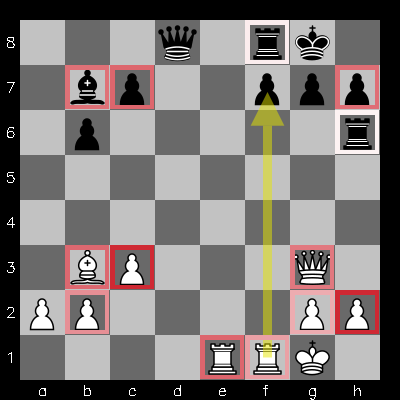

In [9]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results_no_action, chess.Move.from_uci(optimal_action))
display(Image(path))

# Sarfa Baseline with Defined Action

Ensure that the calculations are all supported even when the action is predefined. We need to ensure the particular action is supported in the perturbed board or otherwise ignore running the saliency calculation

In [10]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
board = chess.Board(FEN)

perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board)

action: chess.Move = chess.Move.from_uci("g3c7")

In [11]:
saliency_results_action: dict[str, float] = defaultdict(int)
optimal_action, optimal_action_q = None, float('-inf')

for perturbed_board, perturbed_position_str in perturber.process():

    sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

    # update saliency for the specific position on board
    saliency_results_action[perturbed_position_str] = sarfa_compute_result.saliency
    print(f"{perturbed_position_str} removed: {sarfa_compute_result.saliency}")

    # update the optimal action
    if sarfa_compute_result.optimal_move_q_val > optimal_action_q:
        optimal_action = sarfa_compute_result.optimal_move

a2 removed: 0.36583399783043374
b2 removed: 0.0022594391663370594
b3 removed: 0.6754513519805313
b6 removed: 0
b7 removed: 0.6741860507534687
c3 removed: 0.9777119754969923
c7 removed: 0.7340581221706467
d8 removed: 0.038493068071150875
e1 removed: 0.7748362749724677
f1 removed: 0.35030010497346786
f7 removed: 0
f8 removed: 0.07994934191522927
g2 removed: 0.37144256646501667
g3 removed: 0.6175467698490901
g7 removed: 0
h2 removed: 0.9436266521904618
h6 removed: 0
h7 removed: 0.6544383213568519


Notice that in the above, B6 does not have a calculation because the stated action would be an invalid action given that perturbation.

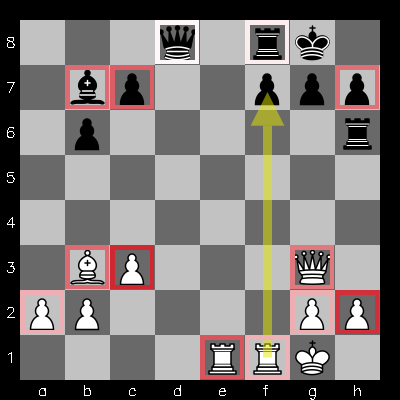

In [12]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results_action, chess.Move.from_uci(optimal_action))
display(Image(path))

# Benchmarking

This is the code to generate experimental results for SARFA baseline. The one parameter available is `runtime` which controls how long stockfish can calculate the Q-value.

In [13]:
from chess_dataset import SarfaBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Settings

In [14]:
RUNTIME=2.0
name = f"sarfa_baseline_{int(RUNTIME * 10)}"
name

'sarfa_baseline_20'

In [15]:
# define function with the exact signature Benchmark requires to run
def saliency_algorithm(fen, action=None) -> dict[str, float]:
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board, runtime=RUNTIME)
    for perturbed_board, perturbed_position_str in perturber.process():
        saliency_result = saliency_calculator.compute(perturbed_board, 
        action)
        saliency_results[perturbed_position_str] = saliency_result.saliency

    return saliency_results


## Run

Note that running will run through all 104 data points and save the file to `output/{name}.pkl`. If you pass `sanity_check=True`, it will only run the benchmark for the first 5 test cases.

In [18]:
benchmark = SarfaBenchmark.run(saliency_algorithm, name, sanity_check=True)

2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1
r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1
2r4k/3r1p1p/1p2pP2/p2pPp1P/P2P1Q2/6R1/4B1PK/2q5 w - - 0 1
R4rk1/5bb1/1N1Qpq1p/3pn1p1/3N4/2P2P1P/P5P1/5B1K w - - 0 1
5r1k/bp4pp/1n6/5qN1/1PR5/P2Q3P/5PP1/6K1 w - - 0 1


# Benchmark Analysis

Load a specific benchmark and run and analysis including accuracy and ROC Curve

In [16]:
sarfa_benchmark = SarfaBenchmark.load_results(saliency_algorithm, "sarfa_baseline_20")

In [18]:
f"Accuracy {sarfa_benchmark.accuracy() * 100: .2f}%"

'Accuracy  79.93%'

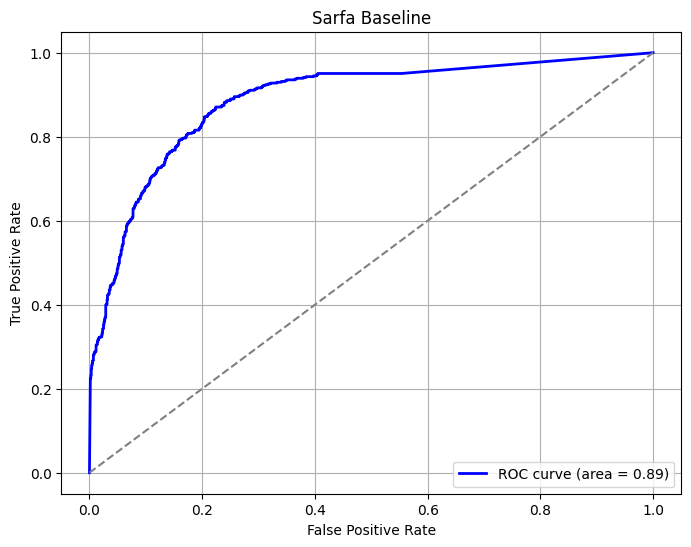

In [19]:
sarfa_benchmark.plot_roc("Sarfa Baseline")

## Specific Case Testing

Template workspace for testing a specific FEN and how the algorithm performs

In [21]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
board = chess.Board(FEN)

board_visualizer = BoardVisualization(board)

legal_moves = list(board.legal_moves)
_, optimal_move = engine.q_values(chess.Board(FEN), legal_moves, multipv=len(legal_moves), runtime=2.0)

saliency_results = saliency_algorithm(FEN)

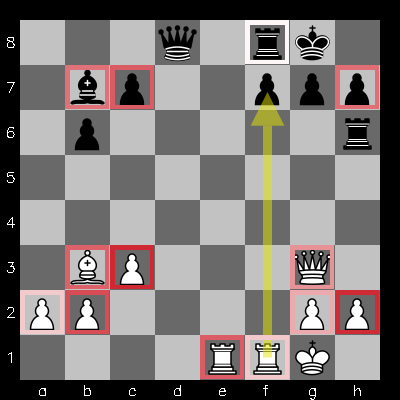

In [22]:
path = board_visualizer.show_heatmap(saliency_results, chess.Move.from_uci(optimal_move))
display(Image(path))

# Conclusion

This analysis is primarly used to develop a baseline implementation of SARFA for benchmarking concerns. Experimental results and analysis is also done through this notebook